<a href="https://colab.research.google.com/github/maoya23/Generative-Model-bigginer/blob/main/lesson5_EMAlgo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 生成モデルを理解する lesson5

###  1. 目的を整理する

そもそも、EMアルゴリズムの意義とは何であったかを思い出す。

- 多峰性のないガウス分布のパラメータを推定するときは、その次元に関わらず平均を取ればよかった。

- ところが、混合ガウス分布においては尤度関数から最尤推定するのは解析的に不可能なのでEMアルゴを使う。

In [1]:
#ライブラリのインストール
import numpy as np
from scipy.stats import multivariate_normal # 多次元ガウス分布
import matplotlib.pyplot as plt

### 2. 真の分布をまず設定してみる

$k$個の$D$次元のガウス分布からなる混合ガウス分布
$$
p(x) = \sum_{k=1}^{K} \pi_k N(x|\mu_k, \Sigma_k)
$$とする。</br>
また各データにおけるクラスタの割り当てをカテゴリカル分布
$$
Cat(Z_{n}|\pi)
$$
によって行う。

- ここで、$\pi_{k}$は混合係数であり、クラスターの重みを表す

真の平均と共分散行列、混合係数を与えてみる。</br>
データが2次元、山が3つなので、それぞれの変数はは3次元の配列で要素が2個になる。

In [2]:
# 次元数を設定:(固定)
D = 2

# クラスタ数を指定
K = 3

# K個の真の平均を指定
mu_truth_kd = np.array(
    [[5.0, 35.0],
     [-20.0, -10.0],
     [30.0, -20.0]]
)

# K個の真の共分散行列を指定
sigma2_truth_kdd = np.array(
    [[[250.0, 65.0], [65.0, 270.0]],
     [[125.0, -45.0], [-45.0, 175.0]],
     [[210.0, -15.0], [-15.0, 250.0]]]
)

# 真の混合係数を指定
pi_truth_k = np.array([0.45, 0.25, 0.3])

#### 2.1 グラフの作図
グラフを書いてみる。前半の方は描画のために設定しているので特に気にする必要はない


In [3]:
# 作図用のx軸のxの値を作成
x_1_line = np.linspace(
    np.min(mu_truth_kd[:, 0] - 3 * np.sqrt(sigma2_truth_kdd[:, 0, 0])),
    np.max(mu_truth_kd[:, 0] + 3 * np.sqrt(sigma2_truth_kdd[:, 0, 0])),
    num=300
)

# 作図用のy軸のxの値を作成
x_2_line = np.linspace(
    np.min(mu_truth_kd[:, 1] - 3 * np.sqrt(sigma2_truth_kdd[:, 1, 1])),
    np.max(mu_truth_kd[:, 1] + 3 * np.sqrt(sigma2_truth_kdd[:, 1, 1])),
    num=300
)

# 作図用の格子状の点を作成
x_1_grid, x_2_grid = np.meshgrid(x_1_line, x_2_line)

# 作図用のxの点を作成
x_point_arr = np.stack([x_1_grid.flatten(), x_2_grid.flatten()], axis=1)

# 作図用に各次元の要素数を保存
x_dim = x_1_grid.shape

$$
p(x) = \sum_{k=1}^{K} \pi_k N(x|\mu_k, \Sigma_k)
$$

多次元ガウス分布の式に従って確立密度の計算をする

In [4]:
# 真の分布を計算
model_dens = 0
for k in range(K):
    # クラスタkの分布の確率密度を計算
    tmp_dens = multivariate_normal.pdf(
        x=x_point_arr, mean=mu_truth_kd[k], cov=sigma2_truth_kdd[k]
    )

    # K個の分布を線形結合
    model_dens += pi_truth_k[k] * tmp_dens

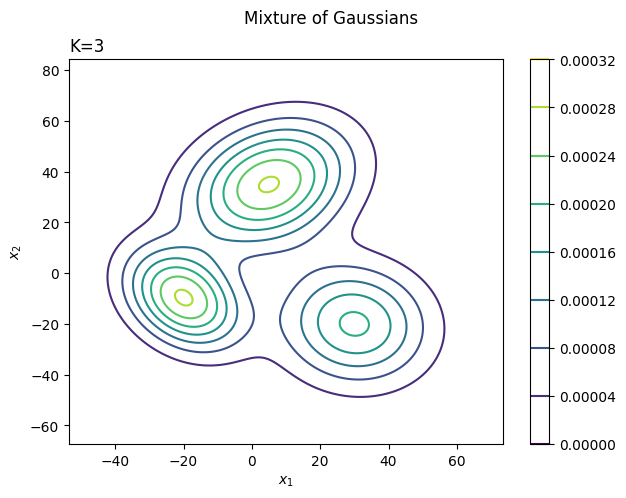

In [5]:
# 真の分布を作図
plt.figure(figsize=(7, 5))
plt.contour(x_1_grid, x_2_grid, model_dens.reshape(x_dim)) # 真の分布
plt.suptitle('Mixture of Gaussians')
plt.title('K=' + str(K), loc='left')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar() # 等高線の色
plt.show()

### 3.データの生成

- まず、潜在変数$Z_{n}$を設定する。</br>
ここでの$Z_{n}$は「データ$X_{n}$がくらす$k$に所属しいているかどうか」を示す。
- $Z_{n}$はワンホットベクトルで$z_{nk}=1$の時は、データ$X_{n}$がクラスタ$k$に所属していることを表す。
</br>
つまり、$p(Z_{nk}=1)=\pi_{k}$である。

- ここで、クラスタの割り当てはカテゴリ分布に従うことを仮定したので以下のようにしてクラスタが得られる。

In [6]:
# (観測)データ数を指定
N = 250

# 潜在変数を生成
z_truth_nk = np.random.multinomial(n=1, pvals=pi_truth_k, size=N)#カテゴリ分布からデータをランダムに生成

z_truth_nk[:5]#クラスタを可視化する

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1]])

In [7]:
# クラスタがあるインデックスの値を抽出する
_, z_truth_n = np.where(z_truth_nk == 1)

# 確認
print(z_truth_n[:5])


[2 1 0 0 2]


In [8]:
# (観測)データを生成
x_nd = np.array([
    np.random.multivariate_normal(
        mean=mu_truth_kd[k], cov=sigma2_truth_kdd[k], size=1#平均と分散の配列の中からクラスタの箇所だけを取り出す
    ).flatten() for k in z_truth_n
])


print(x_nd[:5])
print(len(x_nd))

[[ 34.94362853 -11.99071757]
 [-33.80479893 -27.13056948]
 [ -6.47372479  11.44095314]
 [ 28.44795484  49.33860246]
 [ 39.11301381 -19.24437104]]
250


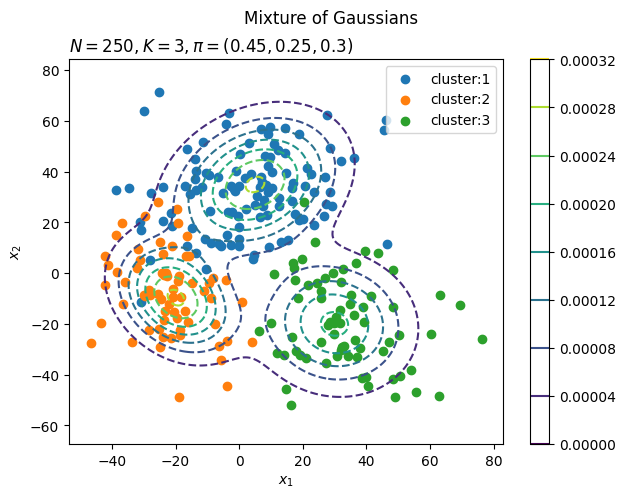

In [9]:
# 観測データの散布図を作成
plt.figure(figsize=(7, 5))
for k in range(K):
    k_idx, = np.where(z_truth_n == k) # クラスタkのデータのインデック
    plt.scatter(x=x_nd[k_idx, 0], y=x_nd[k_idx, 1], label='cluster:' + str(k + 1)) # 観測データ
plt.contour(x_1_grid, x_2_grid, model_dens.reshape(x_dim), linestyles='--') # 真の分布
plt.suptitle('Mixture of Gaussians')
plt.title('$N=' + str(N) + ', K=' + str(K) +
          ', \pi=(' + ', '.join([str(pi) for pi in pi_truth_k]) + ')$', loc='left')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar() # 等高線の色
plt.legend()
plt.show()

### 4. EMアルゴリズムのstep


1. 対数尤度関数$logp(X|θ)$を求めたいが、求まらない時に任意の確率密度関数$q(Z)$を用いてイェンツェンの不等式を使う。
2. イェンツェンの不等式から下限が決まる（エビデンス下界）
1. エビデンス下界と尤度関数との距離を測るとなんと、事後分布とのKLダイバージェンスに一致
1. $q(Z)$は任意の確率密度関数なので$q(Z)$を事後分布に設定すればKL=0になる
1. するとエビデンス下界が押し上げられ、尤度関数の値に等しくなる。
1. 更新した値を元にもう一度対数尤度関数を計算する

以上を収束するまで繰り返し


- 最大化された下限の関数をQ関数という。Q関数は潜在変数の事後分布に関する対数尤度関数の期待値に相当する。

$$
Q_{ML}(θ,\theta^{old})=\sum_{Z}p(Z|X,\theta^{old})log p(X,Z|\theta)
$$

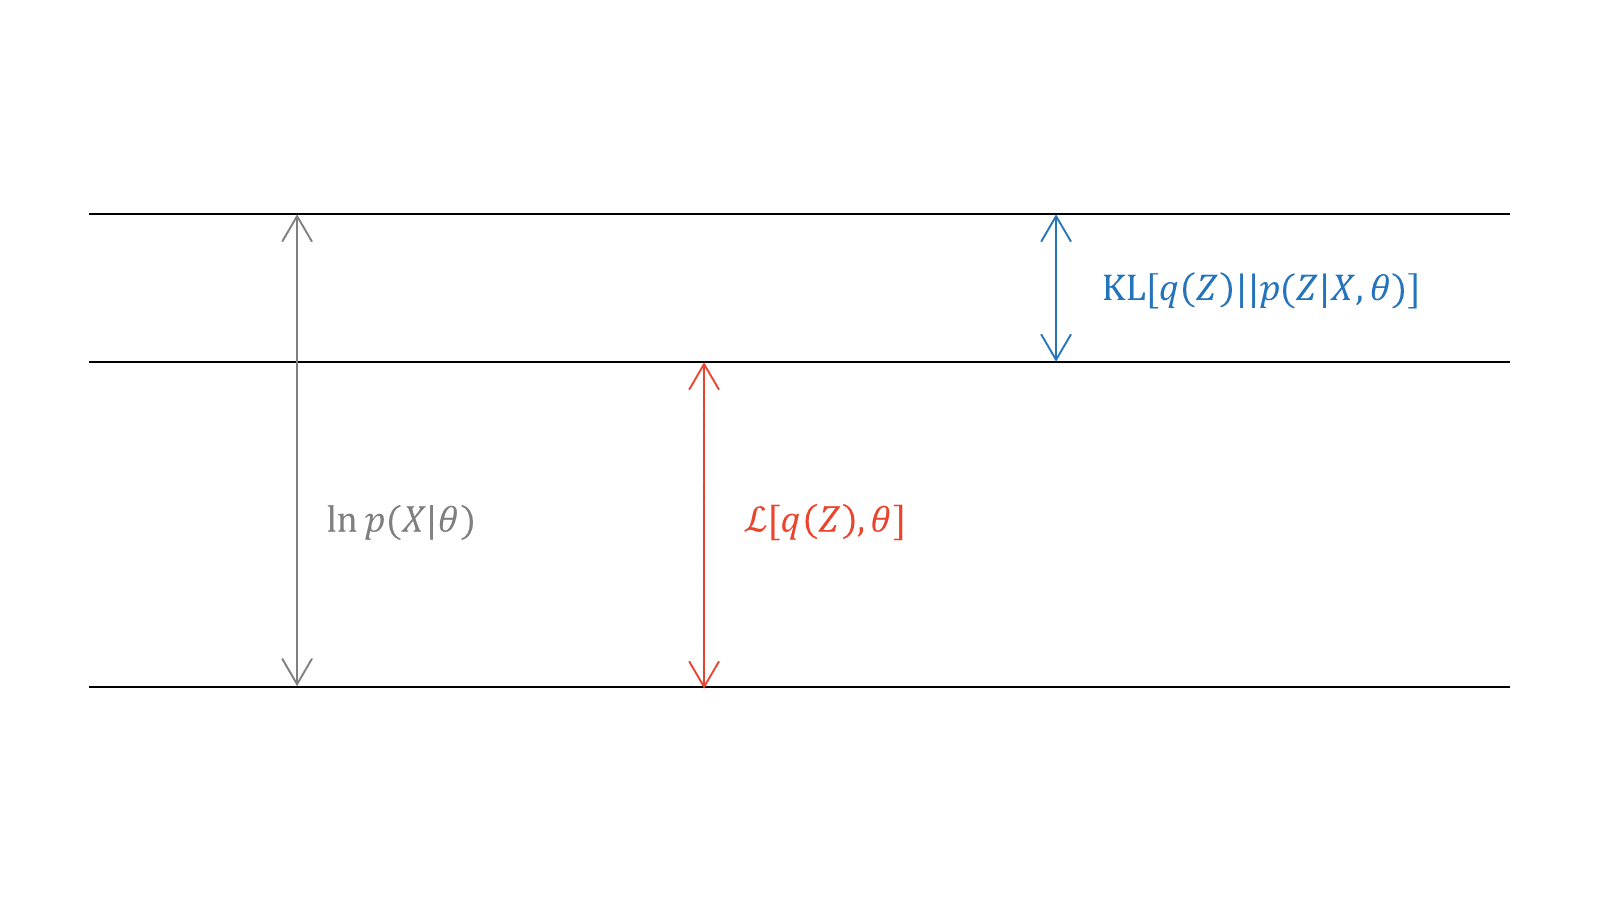

### 5. 混合ガウス分布への適用

- 求めたいパラメータは、平均（$\mu$）,共分散（$\Sigma$）,混合係数（$\pi$）
</br>
</br></br>

混合ガウス分布の尤度関数を$L(\pi,\mu,\Sigma)$とすると
$$
L(\pi,\mu,\Sigma) = \prod_{n=1}^{K} \sum_{k=1}^{K}(\pi_{k}N(x_{n}|\mu_{k},Σ_{k}))^{z_{nk}}
$$
であり、対数尤度$logL(\pi,\mu,\Sigma)$は

$$
logL(\pi,\mu,\Sigma) = z_{nk}\sum_{n=1}^{K}log[ \sum_{k=1}^{K}\pi_{k}N(x_{n}|\mu_{k},Σ_{k})]
$$

$\sum$の中に$log$がある式は解けないのでEMアルゴを使って解くしかない

#### 5.1 Estep

1. 事後確率を上と同様に求める。

$$
p(Z|X,\theta)=\prod_{n=1}^{K} \sum_{k=1}^{K}(\pi_{k}N(x_{n}|\mu_{k},Σ_{k}))^{z_{nk}}
$$

2. Q関数を求める。
$$
Q(\theta,\theta^{old})=E_{Z|X,\theta^{old}}[logp(X,Z|\theta)]
$$

ここで、$E_{Z|X,\theta^{old}}$は以下のように書くことができる。

$$
E_{Z|X,\theta^{old}}=\sum_{Z_{n}}z_{nk}・p(z_{nk}|x_{n},\theta^{old})
$$

これを計算していくと以下の式に変形され、これを$r_{nk}$として、負担率と呼ぶ

$$
\gamma_{nk} = \frac{\pi_k {N}(x_n|\mu_k, \Sigma_k)}{\sum_{j=1}^{K} \pi_j {N}(x_n|\mu_j, \Sigma_j)}
$$

ここで、負担率はどのデータがどのクラスタにどの程度所属しているかを示している



#### 5.2 Mstep

3. さて、もとまったQ関数のそれぞれのパラメータにおける最大値をラグランジュの未定乗数決定法で求める

結果的に得られるのは以下の値。

$$
\hat{\pi}_k = \frac{N_k}{N}
$$

$$
\hat{\bf \mu}_k = \frac{1}{N_k}\sum_{i=1}^N\gamma(z_{ik}){\bf x}_i
$$

$$
\hat{\Sigma}_k = \frac{1}{N_k}\sum_{i=1}^N\gamma(z_{ik})({\bf x}_i - \hat{\bf \mu}_k)({\bf x}_i - \hat{\bf \mu}_k)^T
$$

$$
ただし，
N_k = \sum_{n=1}^N\gamma(z_{ik})
$$


### 6.EMアルゴリズムの実装

お疲れ様です。実装です。

In [10]:
# 平均パラメータの初期値を一様分布からランダムに生成
mu_kd = np.array([
    np.random.uniform(
        low=np.min(x_nd[:, d]), high=np.max(x_nd[:, d]), size=K
    ) for d in range(D)
]).T

# 共分散行列の初期値を指定
sigma2_kdd = np.array([np.identity(D) * 1000 for _ in range(K)]) # np.identityは単位行列を生成

# 混合係数の初期値を生成
pi_k = np.random.rand(3)
pi_k /= np.sum(pi_k) # 正規化

print(mu_kd)
print(sigma2_kdd)
print(pi_k)

[[68.76403462 11.50720768]
 [-6.48942252 -5.95100165]
 [ 9.43630332 -8.57434298]]
[[[1000.    0.]
  [   0. 1000.]]

 [[1000.    0.]
  [   0. 1000.]]

 [[1000.    0.]
  [   0. 1000.]]]
[0.51906644 0.29601379 0.18491977]


In [11]:
# 初期値による混合分布を計算
init_dens = 0
for k in range(K):
    # クラスタkの分布の確率密度を計算
    tmp_dens = multivariate_normal.pdf(
        x=x_point_arr, mean=mu_kd[k], cov=sigma2_kdd[k]
    )

    # K個の分布線形結合
    init_dens += pi_k[k] * tmp_dens

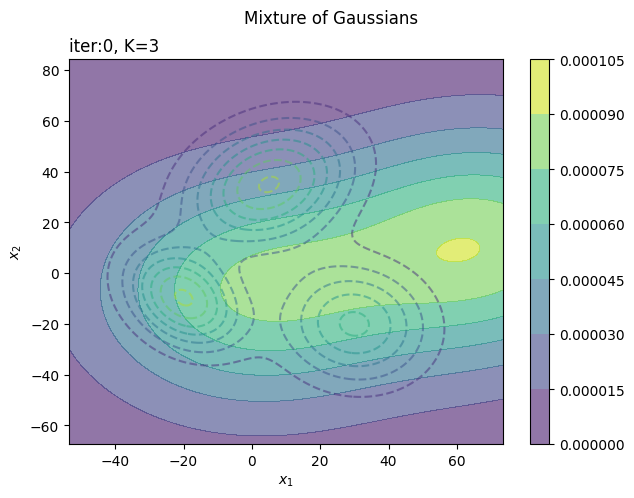

In [12]:
# 初期値による分布を作図
plt.figure(figsize=(7, 5))
plt.contour(x_1_grid, x_2_grid, model_dens.reshape(x_dim),
            alpha=0.5, linestyles='dashed') # 真の分布
#plt.contour(x_1_grid, x_2_grid, init_dens.reshape(x_dim)) # 推定値による分布:(等高線)
plt.contourf(x_1_grid, x_2_grid, init_dens.reshape(x_dim), alpha=0.6) # 推定値による分布:(塗りつぶし)
plt.suptitle('Mixture of Gaussians')
plt.title('iter:' + str(0) + ', K=' + str(K), loc='left')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar() # 等高線の色
plt.show()

In [13]:
# 初期値による対数尤度を計算
term_dens_nk = np.array(
    [multivariate_normal.pdf(x=x_nd, mean=mu_kd[k], cov=sigma2_kdd[k]) for k in range(K)]
).T
L = np.sum(np.log(np.sum(term_dens_nk, axis=1)))

L

-2179.549655755785

さて、推論をしていきます

In [14]:
# 試行回数を指定
MaxIter = 20

# 推移の確認用の受け皿を作成
trace_L_i = [L]
trace_gamma_ink = [np.tile(np.nan, reps=(N, K))]
trace_mu_ikd = [mu_kd.copy()]
trace_sigma2_ikdd = [sigma2_kdd.copy()]
trace_pi_ik = [pi_k.copy()]


In [22]:
from tqdm import tqdm
# 最尤推定
for i in tqdm(range(MaxIter)):

    # 負担率を計算
    gamma_nk = np.array(
        [multivariate_normal.pdf(x=x_nd, mean=mu_kd[k], cov=sigma2_kdd[k]) for k in range(K)]
    ).T
    gamma_nk /= np.sum(gamma_nk, axis=1, keepdims=True) # 正規化

    if i%10==0:#10stepごとに表示
      print('負担率の表示')
      print(np.round(gamma_nk[:5], 3))
      print(np.sum(gamma_nk[:5], axis=1))
      print('\n')

    # 各クラスタとなるデータ数の期待値を計算
    N_k = np.sum(gamma_nk, axis=0)

    if i%10==0:#1stepごとに表示
      print('クラスタが割り当てられた時の期待値')
      print(N_k)
      print('\n')

    for k in range(K):#パラメータの更新を行なっている
        # 平均パラメータの最尤解を計算
        mu_kd[k] = np.dot(gamma_nk[:, k], x_nd) / N_k[k]

        # 共分散行列の最尤解を計算
        term_x_nd = x_nd - mu_kd[k]
        sigma2_kdd[k] = np.dot(gamma_nk[:, k] * term_x_nd.T, term_x_nd) / N_k[k]

    # 混合係数の最尤解を計算
    pi_k = N_k / N

    # 対数尤度を計算
    tmp_dens_nk = np.array(
        [multivariate_normal.pdf(x=x_nd, mean=mu_kd[k], cov=sigma2_kdd[k]) for k in range(K)]
    ).T
    L = np.sum(np.log(np.sum(tmp_dens_nk, axis=1)))

    # i回目の結果を記録
    trace_L_i.append(L)
    trace_gamma_ink.append(gamma_nk.copy())
    trace_mu_ikd.append(mu_kd.copy())
    trace_sigma2_ikdd.append(sigma2_kdd.copy())
    trace_pi_ik.append(pi_k.copy())


100%|██████████| 20/20 [00:00<00:00, 175.97it/s]

負担率の表示
[[1.    0.    0.   ]
 [0.    0.04  0.96 ]
 [0.016 0.552 0.432]
 [0.001 0.997 0.002]
 [1.    0.    0.   ]]
[1. 1. 1. 1. 1.]


クラスタが割り当てられた時の期待値
[77.00960198 86.68326518 86.30713284]


負担率の表示
[[1.    0.    0.   ]
 [0.001 0.    0.999]
 [0.041 0.46  0.499]
 [0.001 0.999 0.   ]
 [1.    0.    0.   ]]
[1. 1. 1. 1. 1.]


クラスタが割り当てられた時の期待値
[78.16468394 85.95638167 85.87893439]




### 7. 推論結果の表示

In [16]:
# 最後の更新値による混合分布を計算
res_dens = 0
for k in range(K):
    # クラスタkの分布の確率密度を計算
    tmp_dens = multivariate_normal.pdf(
        x=x_point_arr, mean=mu_kd[k], cov=sigma2_kdd[k]
    )

    # K個の分布を線形結合
    res_dens += pi_k[k] * tmp_dens

In [17]:
# 負担率が最大のクラスタ番号を抽出
z_n = np.argmax(gamma_nk, axis=1)

# 割り当てられたクラスタとなる負担率(確率)を抽出
prob_z_n = gamma_nk[np.arange(N), z_n]

# 確認
print(z_n[:5])
print(prob_z_n[:5])

[0 1 1 2 0]
[0.90069535 0.73896846 0.64187469 0.56055064 0.9344394 ]


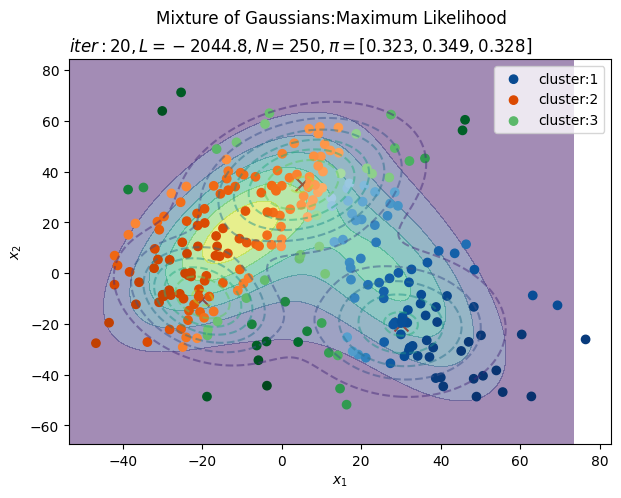

In [18]:
# K個のカラーマップを指定
colormap_list = ['Blues', 'Oranges', 'Greens']

# 負担率が最大のクラスタ番号を抽出
z_n = np.argmax(gamma_nk, axis=1)

# 割り当てられたクラスタとなる負担率(確率)を抽出
prob_z_n = gamma_nk[np.arange(N), z_n]

# 最後の更新値による混合分布を計算
res_dens = 0
for k in range(K):
    # クラスタkの分布の確率密度を計算
    tmp_dens = multivariate_normal.pdf(
        x=x_point_arr, mean=mu_kd[k], cov=sigma2_kdd[k]
    )

    # K個の分布を線形結合
    res_dens += pi_k[k] * tmp_dens

# 最後の更新値による分布を作図
plt.figure(figsize=(7, 5))
plt.contour(x_1_grid, x_2_grid, model_dens.reshape(x_dim),
            alpha=0.5, linestyles='dashed') # 真の分布
plt.scatter(x=mu_truth_kd[:, 0], y=mu_truth_kd[:, 1],
            color='red', s=100, marker='x') # 真の平均
plt.contourf(x_1_grid, x_2_grid, res_dens.reshape(x_dim), alpha=0.5) # 推定値による分布:(塗りつぶし)
for k in range(K):
    k_idx, = np.where(z_n == k) # クラスタkのデータのインデックス
    cm = plt.get_cmap(colormap_list[k]) # クラスタkのカラーマップを設定
    plt.scatter(x=x_nd[k_idx, 0], y=x_nd[k_idx, 1],
                c=[cm(p) for p in prob_z_n[k_idx]], label='cluster:' + str(k + 1)) # 負担率によるクラスタ
#plt.contour(x_1_grid, x_2_grid, res_density.reshape(x_dim)) # 推定値による分布:(等高線)
#plt.colorbar() # 等高線の値:(等高線用)
plt.suptitle('Mixture of Gaussians:Maximum Likelihood')
plt.title('$iter:' + str(MaxIter) +
          ', L=' + str(np.round(L, 1)) +
          ', N=' + str(N) +
          ', \pi=[' + ', '.join([str(pi) for pi in np.round(pi_k, 3)]) + ']$',
          loc='left')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

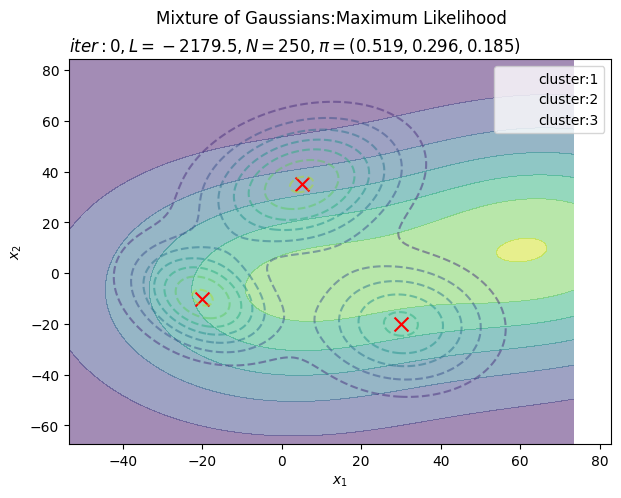

In [19]:
import matplotlib.animation as animation

# K個のカラーマップを指定
colormap_list = ['Blues', 'Oranges', 'Greens']

# 画像サイズを指定
fig = plt.figure(figsize=(7, 5))

# 作図処理を関数として定義
def update_model(i):
    # i回目の更新値による混合分布を計算
    res_dens = 0
    for k in range(K):
        # クラスタkの分布の確率密度を計算
        tmp_dens = multivariate_normal.pdf(
            x=x_point_arr, mean=trace_mu_ikd[i][k], cov=trace_sigma2_ikdd[i][k]
        )

        # K個の分布を線形結合
        res_dens += trace_pi_ik[i][k] * tmp_dens

    # 前フレームのグラフを初期化
    plt.cla()

    # i回目の負担率を取得
    gamma_nk = trace_gamma_ink[i]

    # i回目のサンプルによる分布を作図
    plt.contour(x_1_grid, x_2_grid, model_dens.reshape(x_dim),
                alpha=0.5, linestyles='dashed') # 真の分布
    #plt.contour(x_1_grid, x_2_grid, res_dens.reshape(x_dim)) # 推定値による分布:(等高線)
    plt.contourf(x_1_grid, x_2_grid, res_dens.reshape(x_dim), alpha=0.5) # 推定値による分布:(塗りつぶし)
    plt.scatter(x=mu_truth_kd[:, 0], y=mu_truth_kd[:, 1],
                color='red', s=100, marker='x') # 真の平均
    for k in range(K):
        k_idx, = np.where(np.argmax(gamma_nk, axis=1) == k)
        cm = plt.get_cmap(colormap_list[k]) # クラスタkのカラーマップを設定
        plt.scatter(x=x_nd[k_idx, 0], y=x_nd[k_idx, 1],
                    c=[cm(p) for p in gamma_nk[k_idx, k]], label='cluster:' + str(k + 1)) # 負担率によるクラスタ
        plt.suptitle('Mixture of Gaussians:Maximum Likelihood')
    plt.title('$iter:' + str(i) +
              ', L=' + str(np.round(trace_L_i[i], 1)) +
              ', N=' + str(N) +
              ', \pi=(' + ', '.join([str(pi) for pi in np.round(trace_pi_ik[i], 3)]) + ')$',
              loc='left')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend()

# gif画像を作成
model_anime = animation.FuncAnimation(fig, update_model, frames=MaxIter + 1, interval=100)
model_anime.save("ch9_2_2_Model_f.gif")

## 参考にしたサイト

[【Python】9.2.2：混合ガウス分布のEMアルゴリズムの実装【PRMLのノート】](https://www.anarchive-beta.com/entry/2021/05/25/075812)

[【徹底解説】EMアルゴリズムをはじめからていねいに](https://academ-aid.com/ml/em)